# Data Prep

In [6]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications import Xception, EfficientNetV2S
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report, matthews_corrcoef
)

# Load the CSV file
df = pd.read_csv('../datasets/peheaders/Ransomware_headers.csv')

# Directory to save the images
output_dir = '../datasets/peheaders/images'
os.makedirs(output_dir, exist_ok=True)

2024-08-21 15:01:41.043110: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 15:01:41.224481: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 15:01:41.281316: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 15:01:41.310597: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 15:01:41.416105: I tensorflow/core/platform/cpu_feature_guar

In [7]:
# Function to convert the byte sequence to a 32x32 image and upscale it to 256x256
def bytes_to_image(byte_sequence, output_path=None):
    # Ensure byte_sequence is a numpy array of type uint8
    byte_sequence = np.array(byte_sequence, dtype=np.uint8)
    
    # Convert byte sequence into a 32x32 numpy array and normalize
    norm_array = byte_sequence.reshape(32, 32) / 255.0
    
    # Apply a color map (e.g., "Spectral") from seaborn to create a color image
    color_map = sns.color_palette("Spectral_r", as_cmap=True)
    color_mapped_array = color_map(norm_array)
    color_mapped_array = (color_mapped_array[:, :, :3] * 255).astype(np.uint8)  # Remove alpha channel and convert to uint8
    
    # Convert to PIL image
    img = Image.fromarray(color_mapped_array)
    
    # Resize the image to 256x256 with each original pixel expanded to 64 pixels
    img = img.resize((256, 256), resample=Image.NEAREST)
    
    if output_path is not None:
        # Save the image
        img.save(output_path)
    
    return np.array(img)

In [ ]:
# Iterate over the dataframe rows to create and save images
for index, row in df.iterrows():
    # Extract the byte sequence (columns 5 to 1028)
    byte_sequence = row[4:].values
    # Generate the filename for the image
    img_filename = f"{row['ID']}_{row['GR']}.png"
    output_path = os.path.join(output_dir, img_filename)
    # Convert the byte sequence to an image and save it
    bytes_to_image(byte_sequence, output_path)

print(f"256x256 images have been saved to {output_dir}")

## Split the data into Training, Test and Validation

In [8]:
from sklearn.model_selection import train_test_split

# Function to split the data into training, validation, and test sets
def split_data(df, train_size=0.6, val_size=0.2, test_size=0.2):
    # Ensure the split sizes sum to 1
    assert train_size + val_size + test_size == 1, "Train, validation, and test sizes must sum to 1"
    
    # Split the data into train and temp (val + test)
    train_df, temp_df = train_test_split(df, train_size=train_size, random_state=42, stratify=df['GR'])
    
    # Calculate the validation proportion of the remaining data
    val_prop = val_size / (val_size + test_size)
    
    # Split the remaining data into validation and test
    val_df, test_df = train_test_split(temp_df, train_size=val_prop, random_state=42, stratify=temp_df['GR'])
    
    return train_df, val_df, test_df

# Split the data
train_df, val_df, test_df = split_data(df)

In [9]:
# Data structure to hold the images and labels
data = {
    'train': [],
    'validation': [],
    'test': []
}

# Function to populate the data structure
def populate_data_structure(df, subset_name):
    for index, row in df.iterrows():
        # Extract the byte sequence (columns 5 to 1028)
        byte_sequence = row[4:].values
        # Convert the byte sequence to an image
        image = bytes_to_image(byte_sequence)
        # Get the label
        label = row['GR']
        # Append the image and label as a tuple to the corresponding subset
        data[subset_name].append((image, label))

# Populate the data structure for each subset
populate_data_structure(train_df, 'train')
populate_data_structure(val_df, 'validation')
populate_data_structure(test_df, 'test')

print("Data structure populated with training, validation, and test sets.")

Data structure populated with training, validation, and test sets.


In [24]:
import tensorflow as tf
import gc

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth has been set for GPU.")
    except RuntimeError as e:
        print(e)

# Clear TensorFlow session
tf.keras.backend.clear_session()

# Optionally, delete the model and other variables
#del model

# Force garbage collection
gc.collect()

# If you're using TensorFlow 2.x and want to clear GPU memory, you can reset the context:
tf.config.experimental.reset_memory_stats(device='GPU:0')

print("GPU memory has been cleared.")

Memory growth has been set for GPU.
GPU memory has been cleared.


# XCeption Net

In [7]:
# Function to create the CNN model
def create_xception_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Xception(weights=None, include_top=True, input_shape=input_shape, classes=1, classifier_activation='sigmoid'))

    
    model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

input_shape = (256, 256, 3)  # Image dimensions

# Create the model
model = create_xception_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 1)              │    20,863,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 20,809,001 (79.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [8]:
# Prepare the data for training
train_data = np.array([item[0] for item in data['train']])
train_labels = np.array([item[1] for item in data['train']])

validation_data = np.array([item[0] for item in data['validation']])
validation_labels = np.array([item[1] for item in data['validation']])

train_data.shape, train_labels.shape, validation_data.shape, validation_labels.shape

((1294, 256, 256, 3), (1294,), (431, 256, 256, 3), (431,))

In [11]:
# Early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='xception_checkpoint_epoch_{epoch:02d}.keras',  # Filename format, save for each epoch
    save_freq='epoch',  # Save at the end of every epoch
    save_weights_only=False,  # Save the entire model (not just weights)
    verbose=0  # Display saving information
)

# Define the CSVLogger callback
csv_logger = CSVLogger(
    filename='xception_training_log.csv',  # The name of the CSV file
    separator=',',  # The separator between columns
    append=False  # Overwrite the file each time (set to True if you want to append)
)

# Train the model
history = model.fit(train_data, train_labels, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(validation_data, validation_labels),
                    callbacks=[checkpoint_callback, csv_logger])

Epoch 1/50


I0000 00:00:1724236813.273801 2042641 service.cc:146] XLA service 0x7958ec0155f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724236813.273836 2042641 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-08-21 12:40:13.953713: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-21 12:40:15.654802: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-08-21 12:40:20.453118: W external/local_tsl/tsl/framework/bfc_allocator.cc:363] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance ove

40/41 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.8161 - loss: 0.3737

E0000 00:00:1724236854.517244 2042641 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724236854.670865 2042641 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-08-21 12:40:56.223074: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.82GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-21 12:40:56.429501: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.84GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more mem

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.8179 - loss: 0.3711

E0000 00:00:1724236870.792745 2042641 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724236870.950426 2042641 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-08-21 12:41:12.444702: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.



Epoch 1: saving model to xception_checkpoint_epoch_01.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 853ms/step - accuracy: 0.8197 - loss: 0.3685 - val_accuracy: 0.4733 - val_loss: 0.6945
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9747 - loss: 0.0970
Epoch 2: saving model to xception_checkpoint_epoch_02.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 349ms/step - accuracy: 0.9747 - loss: 0.0969 - val_accuracy: 0.4733 - val_loss: 0.6963
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9860 - loss: 0.0452
Epoch 3: saving model to xception_checkpoint_epoch_03.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 339ms/step - accuracy: 0.9860 - loss: 0.0451 - val_accuracy: 0.4733 - val_loss: 0.6999
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9964 - loss: 0.0104
Epoch 4: saving model to xception_checkpoint_epoch_04.keras
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 363ms/step - accuracy: 0.9963 - loss: 0.0106 - val_accuracy: 0.4733 - val_loss: 0.7034
Epoch 5/50
41/41 ━━━━━━━━━━━━

In [12]:
# Evaluate the model
test_data = np.array([item[0] for item in data['test']])
test_labels = np.array([item[1] for item in data['test']])
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

13/14 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9881 - loss: 0.0584

E0000 00:00:1724237573.261601 2042644 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724237573.422098 2042644 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2024-08-21 12:52:55.018800: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 389ms/step - accuracy: 0.9869 - loss: 0.0639
Test Accuracy: 97.92%


## Find the best Epoch

In [13]:
# Find the best Epoch
accuracies = np.array([])
for epoch in range(1, 51):
    model = tf.keras.models.load_model(f'xception_checkpoint_epoch_{epoch:02d}.keras')
    _, test_accuracy = model.evaluate(test_data, test_labels)
    accuracies = np.append(accuracies, test_accuracy)

best_epoch = np.argmax(accuracies)
best_accuracy = accuracies[best_epoch]
print(f'Best Epoch: {best_epoch}, Test Accuracy: {best_accuracy * 100:.2f}%')

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.4646 - loss: 0.6949
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.4646 - loss: 0.6971
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4646 - loss: 0.7012
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.4646 - loss: 0.7052
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.4646 - loss: 0.7097
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4646 - loss: 0.7226
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4646 - loss: 0.7505
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.4646 - loss: 0.8072
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.4646 - loss: 0.9319
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.4646 - loss: 1.1273
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.4646 - loss: 1.4081
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.4646 - loss: 1.7944
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.4646 - loss: 2.1785
14/14 ━━━━━━━━━━━━━━━━━━━

## Result Visualization

In [18]:
# Load the best model
model = tf.keras.models.load_model('xception_checkpoint_epoch_26.keras')

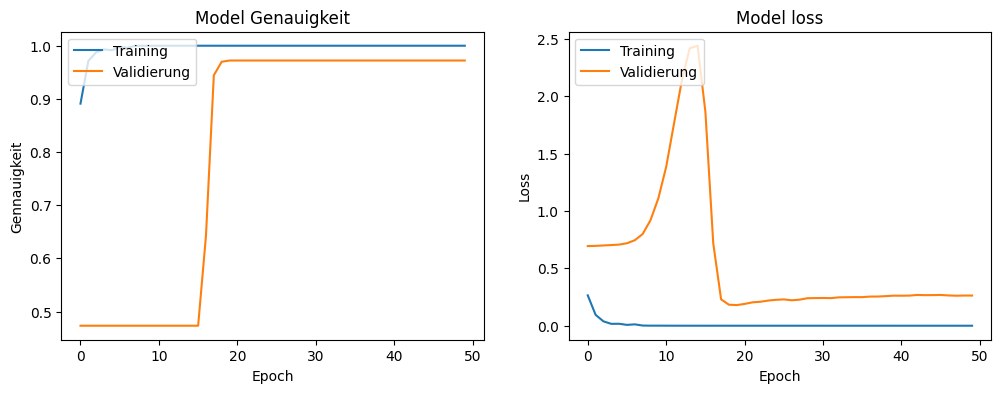

In [14]:
# Plotting the history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Genauigkeit')
plt.xlabel('Epoch')
plt.ylabel('Gennauigkeit')
plt.legend(['Training', 'Validierung'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validierung'], loc='upper left')

plt.show()

In [19]:
# Get the predicted probabilities and predicted classes
predicted_probs = model.predict(test_data)
predicted_classes = (predicted_probs > 0.5).astype(int).flatten()

# Separate the probabilities into two groups based on the true labels
ransomware_probs = predicted_probs[test_labels == 1].flatten()  # Probabilities where the true label is ransomware
benign_probs = predicted_probs[test_labels == 0].flatten()       # Probabilities where the true label is benign

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step


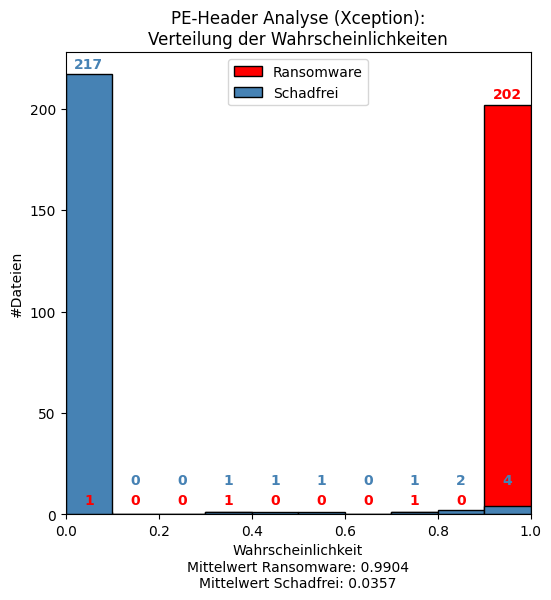

In [23]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Plot histogram of probabilities for each class
_, _, ransom_bars = plt.hist(ransomware_probs, label="Ransomware", range=(0,1), color='red', edgecolor='black')
_, _, benign_bars = plt.hist(benign_probs, label='Schadfrei', range=(0,1), color='steelblue', edgecolor='black')

plt.title(f'PE-Header Analyse (Xception):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')


for bar in ransom_bars:
    if bar.get_height() < 50:
        plt.text(bar.get_x() + bar.get_width() / 2, 5, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 3, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')

for bar in benign_bars:
    if bar.get_height() < 50:
        plt.text(bar.get_x() + bar.get_width() / 2, 15, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 3, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

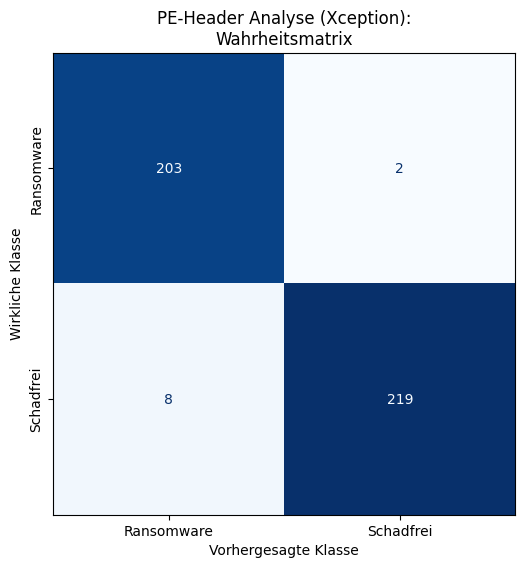

In [24]:
cm = confusion_matrix(test_labels, predicted_classes)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('PE-Header Analyse (Xception):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

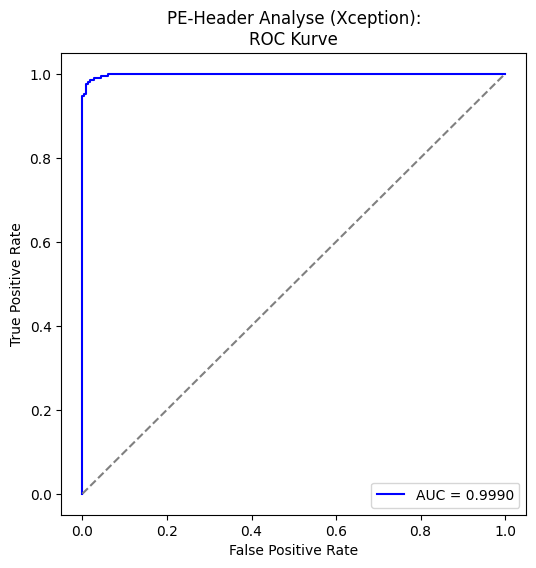

Bester Grenzwert: 0.9050132036209106


In [25]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predicted_probs)

# Calculate AUC
auc = roc_auc_score(test_labels, predicted_probs)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PE-Header Analyse (Xception):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [28]:
for prob in predicted_probs:
    if prob < 0.5:
        predicted_probs[predicted_probs == prob] = 0
    else:
        predicted_probs[predicted_probs == prob] = 1

# Calculate and display classification metrics
accuracy = accuracy_score(test_labels, predicted_probs)
recall = recall_score(test_labels, predicted_probs)
precision = precision_score(test_labels, predicted_probs)
f1 = f1_score(test_labels, predicted_probs)
mcc = (matthews_corrcoef(test_labels, predicted_probs) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(test_labels, predicted_probs, target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Accuracy: 0.9769
Recall (Sensitivity): 0.9902
Precision: 0.9621
F1-Score: 0.9760
AUC: 0.9990
MCC: 0.9770
Wertung: 0.9861

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9910    0.9648    0.9777       227
  Ransomware     0.9621    0.9902    0.9760       205

    accuracy                         0.9769       432
   macro avg     0.9765    0.9775    0.9768       432
weighted avg     0.9773    0.9769    0.9769       432



# EfficientNet Model

In [11]:
# Function to create the CNN model
def create_efficientnet_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(EfficientNetV2S(weights=None, include_top=True, input_shape=input_shape, classes=1, classifier_activation='sigmoid'))

    
    model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

input_shape = (256, 256, 3)  # Image dimensions

# Create the model
model = create_efficientnet_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)   │ (None, 1)              │    20,332,641 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,332,641 (77.56 MB)

 Trainable params: 20,178,769 (76.98 MB)

 Non-trainable params: 153,872 (601.06 KB)

In [12]:
# Prepare the data for training
train_data = np.array([item[0] for item in data['train']])
train_labels = np.array([item[1] for item in data['train']])

validation_data = np.array([item[0] for item in data['validation']])
validation_labels = np.array([item[1] for item in data['validation']])

train_data.shape, train_labels.shape, validation_data.shape, validation_labels.shape

((1294, 256, 256, 3), (1294,), (431, 256, 256, 3), (431,))

In [13]:
# Early stopping
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='enet_checkpoints/enet_checkpoint_epoch_{epoch:02d}.keras',  # Filename format, save for each epoch
    save_freq='epoch',  # Save at the end of every epoch
    save_weights_only=False,  # Save the entire model (not just weights)
    verbose=0  # Dont Display saving information
)

# Define the CSVLogger callback
csv_logger = CSVLogger(
    filename='enet_training_log.csv',  # The name of the CSV file
    separator=',',  # The separator between columns
    append=False  # Overwrite the file each time (set to True if you want to append)
)

# Train the model
history = model.fit(train_data, train_labels, 
                    epochs=50, 
                    batch_size=16, 
                    validation_data=(validation_data, validation_labels),
                    callbacks=[checkpoint_callback, csv_logger])

Epoch 1/50


I0000 00:00:1724245373.849919 2151879 service.cc:146] XLA service 0x7f64b4003240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724245373.849948 2151879 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2024-08-21 15:02:55.410853: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-21 15:02:58.264145: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1724245387.499429 2151879 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724245387.646421 2151879 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Sys

80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5816 - loss: 2.7536

E0000 00:00:1724245439.098794 2151879 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724245439.246234 2151879 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724245439.661447 2151879 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724245439.797286 2151879 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1724245440.172033 2151879 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000

81/81 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.5825 - loss: 2.7305 - val_accuracy: 0.7935 - val_loss: 1.5979
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.6950 - loss: 1.0499 - val_accuracy: 0.7842 - val_loss: 4.4734
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.8300 - loss: 0.7269 - val_accuracy: 0.8956 - val_loss: 0.3227
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 0.8972 - loss: 0.3610 - val_accuracy: 0.9002 - val_loss: 0.9414
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.8804 - loss: 0.4454 - val_accuracy: 0.9188 - val_loss: 0.4277
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 0.8929 - loss: 0.3064 - val_accuracy: 0.9466 - val_loss: 2.1884
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9227 - loss: 0.2234 - val_accuracy: 0.9466 - val_loss: 0.5172
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 0.9333 - loss: 0.1798 - val_accuracy: 0.9582 

In [14]:
# Evaluate the model
test_data = np.array([item[0] for item in data['test']])
test_labels = np.array([item[1] for item in data['test']])
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.9650 - loss: 0.1182
Test Accuracy: 96.30%


In [15]:
# Find the best Epoch
accuracies = np.array([])
for epoch in range(1, 51):
    model = tf.keras.models.load_model(f'enet_checkpoints/enet_checkpoint_epoch_{epoch:02d}.keras')
    _, test_accuracy = model.evaluate(test_data, test_labels)
    accuracies = np.append(accuracies, test_accuracy)

best_epoch = np.argmax(accuracies)
best_accuracy = accuracies[best_epoch]

print(f'Best Epoch: {best_epoch}, Test Accuracy: {best_accuracy * 100:.2f}%')

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 250ms/step - accuracy: 0.8095 - loss: 0.5896
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.8092 - loss: 0.8250
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.9108 - loss: 0.2653
14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 238ms/step - accuracy: 0.9141 - loss: 0.5195
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 233ms/step - accuracy: 0.9234 - loss: 0.1875
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.9537 - loss: 0.3376
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 238ms/step - accuracy: 0.9511 - loss: 0.2312
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 240ms/step - accuracy: 0.9653 - loss: 0.1706
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.9539 - loss: 0.1429
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.9787 - loss: 0.0779
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.9722 - loss: 0.1117
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.9768 - loss: 0.0897
14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 235ms/step - accuracy: 0.9690 - loss: 0.1243
14/14 ━━━━━━━━━━━━━━━━━━

In [18]:
# Load the best model
model = tf.keras.models.load_model('enet_checkpoints/enet_checkpoint_epoch_28.keras')

## Result Visualization

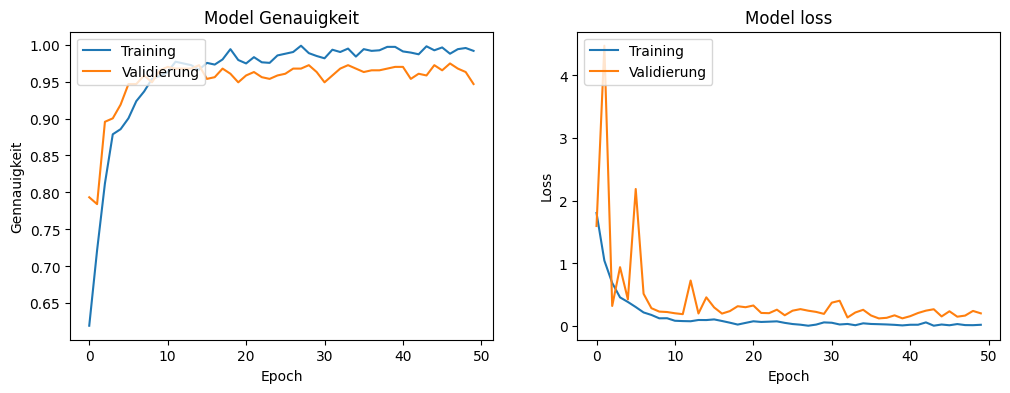

In [16]:
# Plotting the history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Genauigkeit')
plt.xlabel('Epoch')
plt.ylabel('Gennauigkeit')
plt.legend(['Training', 'Validierung'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training', 'Validierung'], loc='upper left')

plt.show()

In [19]:
# Get the predicted probabilities and predicted classes
predicted_probs = model.predict(test_data)
predicted_classes = (predicted_probs > 0.5).astype(int).flatten()

# Separate the probabilities into two groups based on the true labels
ransomware_probs = predicted_probs[test_labels == 1].flatten()  # Probabilities where the true label is ransomware
benign_probs = predicted_probs[test_labels == 0].flatten()       # Probabilities where the true label is benign

14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 390ms/step


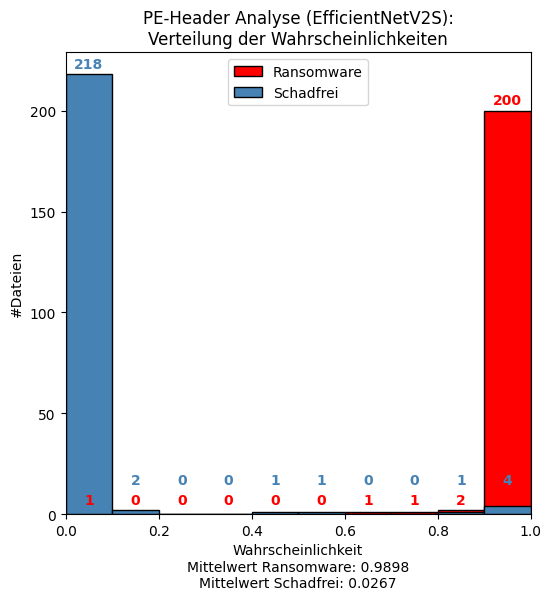

In [20]:
plt.style.use('default')
plt.figure(figsize=(6, 6))

# Plot histogram of probabilities for each class
_, _, ransom_bars = plt.hist(ransomware_probs, label="Ransomware", range=(0,1), color='red', edgecolor='black')
_, _, benign_bars = plt.hist(benign_probs, label='Schadfrei', range=(0,1), color='steelblue', edgecolor='black')

plt.title(f'PE-Header Analyse (EfficientNetV2S):\nVerteilung der Wahrscheinlichkeiten')
plt.xlabel(f'Wahrscheinlichkeit\nMittelwert Ransomware: {ransomware_probs.mean():.4f}\nMittelwert Schadfrei: {benign_probs.mean():.4f}')


for bar in ransom_bars:
    if bar.get_height() < 50:
        plt.text(bar.get_x() + bar.get_width() / 2, 5, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 3, f'{int(bar.get_height())}', ha='center', color='red', fontweight='bold')

for bar in benign_bars:
    if bar.get_height() < 50:
        plt.text(bar.get_x() + bar.get_width() / 2, 15, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')
    else:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 3, f'{int(bar.get_height())}', ha='center', color='steelblue', fontweight='bold')

plt.legend()
plt.xlim(0, 1)
plt.ylabel('#Dateien')
plt.show()

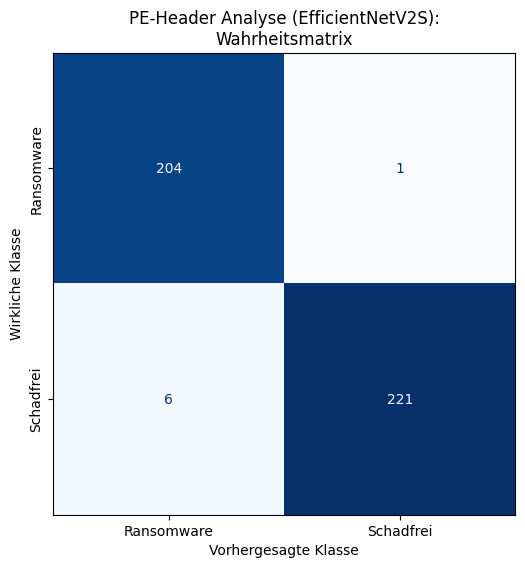

In [21]:
cm = confusion_matrix(test_labels, predicted_classes)
# Reorder confusion matrix to switch classes
cm = cm[[1, 0], :]  # Switch the rows
cm = cm[:, [1, 0]]  # Switch the columns

cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ransomware', 'Schadfrei'])

fig, ax = plt.subplots(figsize=(6, 6))
# Plot confusion matrix
cmd.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
plt.title('PE-Header Analyse (EfficientNetV2S):\nWahrheitsmatrix')
plt.xlabel('Vorhergesagte Klasse')
plt.ylabel('Wirkliche Klasse')
# Rotate x and y axis labels
plt.yticks(rotation=90, va='center')
plt.show()

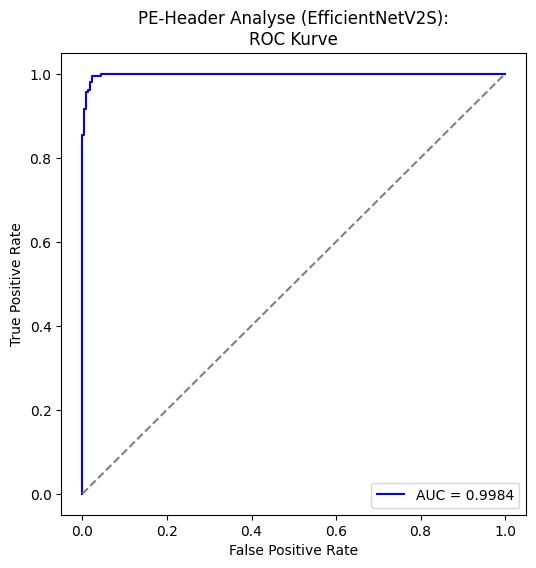

Bester Grenzwert: 0.6865249872207642


In [22]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_labels, predicted_probs)

# Calculate AUC
auc = roc_auc_score(test_labels, predicted_probs)

# Find the best threshold
best_threshold_index = np.argmax(tpr - fpr)
best_threshold = thresholds[best_threshold_index]


# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PE-Header Analyse (EfficientNetV2S):\nROC Kurve')
plt.legend(loc='lower right')
plt.show()

# Print the best threshold
print(f'Bester Grenzwert: {best_threshold}')

In [23]:
for prob in predicted_probs:
    if prob < 0.5:
        predicted_probs[predicted_probs == prob] = 0
    else:
        predicted_probs[predicted_probs == prob] = 1

# Calculate and display classification metrics
accuracy = accuracy_score(test_labels, predicted_probs)
recall = recall_score(test_labels, predicted_probs)
precision = precision_score(test_labels, predicted_probs)
f1 = f1_score(test_labels, predicted_probs)
mcc = (matthews_corrcoef(test_labels, predicted_probs) + 1) / 2
wertung = 0.5 * recall + 0.25 * f1 + 0.125 * auc + 0.125 * mcc
report = classification_report(test_labels, predicted_probs, target_names=['Benign', 'Ransomware'], digits=4)

print(f'Accuracy: {accuracy:.4f}')
print(f'Recall (Sensitivity): {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1-Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'MCC: {mcc:.4f}')
print(f'Wertung: {wertung:.4f}')
print('\nDetailed Classification Report:')
print(report)

Accuracy: 0.9838
Recall (Sensitivity): 0.9951
Precision: 0.9714
F1-Score: 0.9831
AUC: 0.9984
MCC: 0.9839
Wertung: 0.9911

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign     0.9955    0.9736    0.9844       227
  Ransomware     0.9714    0.9951    0.9831       205

    accuracy                         0.9838       432
   macro avg     0.9835    0.9843    0.9838       432
weighted avg     0.9841    0.9838    0.9838       432

